In [156]:
import pandas as pd
import shap
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from PIL import Image, ImageOps
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, ndcg_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from PIL import Image, ImageOps
import lime
import lime.lime_tabular

In [157]:
df = pd.read_csv("NCAA Champion RawData.csv")
df = df.fillna(0)
df.rename(columns={'season': 'Season'}, inplace=True)
print(list(df.columns))

['Season', 'Team', 'team_id', 'conference', 'bracket_region', 'make_tournament', 'round', 'max_player', 'seed_tournament', 'champion_share', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'AP_Pre 1', 'AP_Week 2', 'AP_Week 3', 'AP_Week 4', 'AP_Week 5', 'AP_Week 6', 'AP_Week 7', 'AP_Week 8', 'AP_Week 9', 'AP_Week 10', 'AP_Week 11', 'AP_Week 12', 'AP_Week 13', 'AP_Week 14', 'AP_Week 15', 'AP_Week 16', 'AP_Week 17', 'AP_Week 18', 'champion', 'sum_school_champion_shares', 'sum_school_champions', 'sum_school_finals', 'sum_school_final_fours', 'sum_school_elite_eights', '

In [158]:
data_columns = ['TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'AP_Pre 1', 'AP_Week 2', 'AP_Week 3', 'AP_Week 4', 'AP_Week 5', 'AP_Week 6', 'AP_Week 7', 'AP_Week 8', 'AP_Week 9', 'AP_Week 10', 'AP_Week 11', 'AP_Week 12', 'AP_Week 13', 'AP_Week 14', 'AP_Week 15', 'AP_Week 16', 'AP_Week 17', 'AP_Week 18', 'champion', 'sum_school_champion_shares', 'sum_school_champions', 'sum_school_finals', 'sum_school_final_fours', 'sum_school_elite_eights', 'sum_school_L1S_cs', 'sum_school_L3S_cs', 'sum_school_L5S_cs', 'sum_school_L8S_cs', 'avg_ap_poll_rank_Pre_18', 'make_all_ap_polls', 'top_12_AP_Week 6', 'team_rating_custom', 'max_player_rating_custom', 'sum_player_champion_shares', 'sum_player_champions', 'sum_mm_tour_games', 'sum_cf_tour_games', 'sum_crs_games', 'sum_player_L1S_cs', 'sum_player_L3S_cs', 'sum_player_L5S_cs', 'sum_player_L8S_cs', 'bracket_region_rating', 'conference_rating', 'sum_coach_mm_tour_games', 'sum_coach_L1S_cs', 'sum_coach_L3S_cs', 'sum_coach_L5S_cs', 'sum_coach_L8S_cs', 'sum_conf_L1S_cs', 'sum_conf_L3S_cs', 'sum_conf_L5S_cs', 'sum_conf_L8S_cs', 'top_4_seed', 'rank_team_rating_custom', 'rank_AdjEM', 'rank_AdjOE', 'top_8_team_rating_custom', 'top_6_AdjEM', 'top_6_AdjOE']

df = df.dropna(subset=data_columns)
data = df[data_columns].copy()

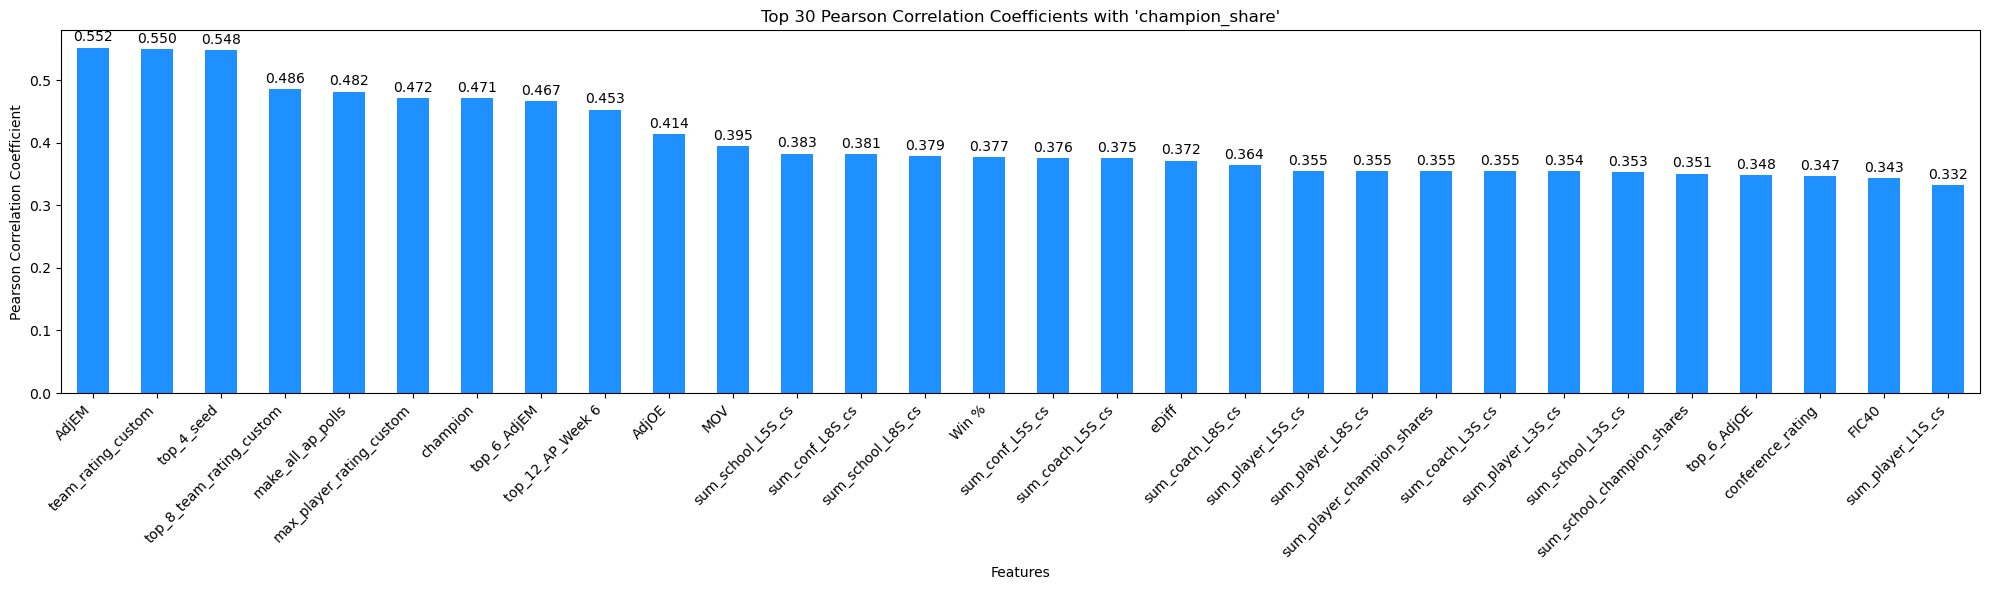

In [159]:

correlations = df[data_columns].corrwith(df['champion_share'])
correlations = correlations.sort_values(ascending=False)

top_correlations = correlations[:30]

plt.figure(figsize=(20, 6))
top_correlations.plot(kind='bar', color='dodgerblue')
plt.title("Top 30 Pearson Correlation Coefficients with 'champion_share'")
plt.xlabel("Features")
plt.ylabel("Pearson Correlation Coefficient")
plt.xticks(rotation=45, ha='right')

for i, val in enumerate(top_correlations):
    plt.text(i, val + 0.01, f'{val:.3f}', ha='center')

plt.tight_layout()
plt.show()

In [160]:
correlation_matrix = data.corr()

correlation_threshold = .7

columns_to_remove = set()
#print("Columns to be Removed:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            if feature_i not in columns_to_remove:
                columns_to_remove.add(feature_j)
                #print(f"{feature_j} (correlated with {feature_i}): {correlation:.2f}")

data_filtered = data.drop(columns=columns_to_remove)

In [161]:
print("Columns in data_filtered:")
print(", ".join(f"'{column}'" for column in data_filtered.columns))

print("\nColumns that were removed:")
print(", ".join(f"'{removed_column}'" for removed_column in columns_to_remove))

Columns in data_filtered:
'TS%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'FIC40', 'DRtg', 'eDiff', 'Poss', 'Pace', 'MPG', '3PM', 'FTM', 'FT%', 'DRB', 'PF', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', 'High Game', 'Techs', 'Ast/TO', 'W's', 'AdjOE', 'AP_Pre 1', 'AP_Week 10', 'champion', 'sum_school_champion_shares', 'sum_school_champions', 'sum_school_finals', 'sum_school_final_fours', 'sum_school_L1S_cs', 'sum_player_champions', 'sum_mm_tour_games', 'sum_cf_tour_games', 'bracket_region_rating', 'conference_rating', 'sum_coach_L3S_cs', 'sum_conf_L5S_cs', 'top_4_seed', 'rank_AdjEM', 'top_8_team_rating_custom', 'top_6_AdjEM', 'top_6_AdjOE'

Columns that were removed:
'sum_conf_L8S_cs', 'FGA', 'FG%', 'AP_Week 4', 'sum_school_elite_eights', 'PPS', 'sum_coach_L8S_cs', 'sum_player_L5S_cs', 'sum_coach_L1S_cs', 'AP_Week 7', 'eFG%', 'make_all_ap_polls', 'ORtg', 'AP_Week 8', 'Total S%', 'max_player_rating_custom', 'L's', 'top_12_AP_Week 6', 'sum_player_L3S_cs', 'su

In [174]:

features = ['top_8_team_rating_custom', 'top_6_AdjEM', 'top_6_AdjOE', 'top_4_seed','top_12_AP_Week 6', 
            
            'TS%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'FIC40', 'DRtg', 'eDiff', 'Poss', 'Pace', 'MPG', '3PM', 'FTM', 'FT%', 'DRB', 'PF', 'Dbl Dbl', 
            'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', 'High Game', 'Techs', 'Ast/TO', 'AdjOE', 'AP_Week 10', 'sum_school_champion_shares',
            'sum_school_champions', 'sum_school_finals', 'sum_school_final_fours', 'sum_school_L1S_cs', 'sum_player_champions', 'sum_mm_tour_games',
            'bracket_region_rating', 'conference_rating', 'sum_coach_L3S_cs', 'sum_conf_L5S_cs',
        
           
           ]


            
num_features = len(features)

print(f"Number of features: {num_features}")

Number of features: 46


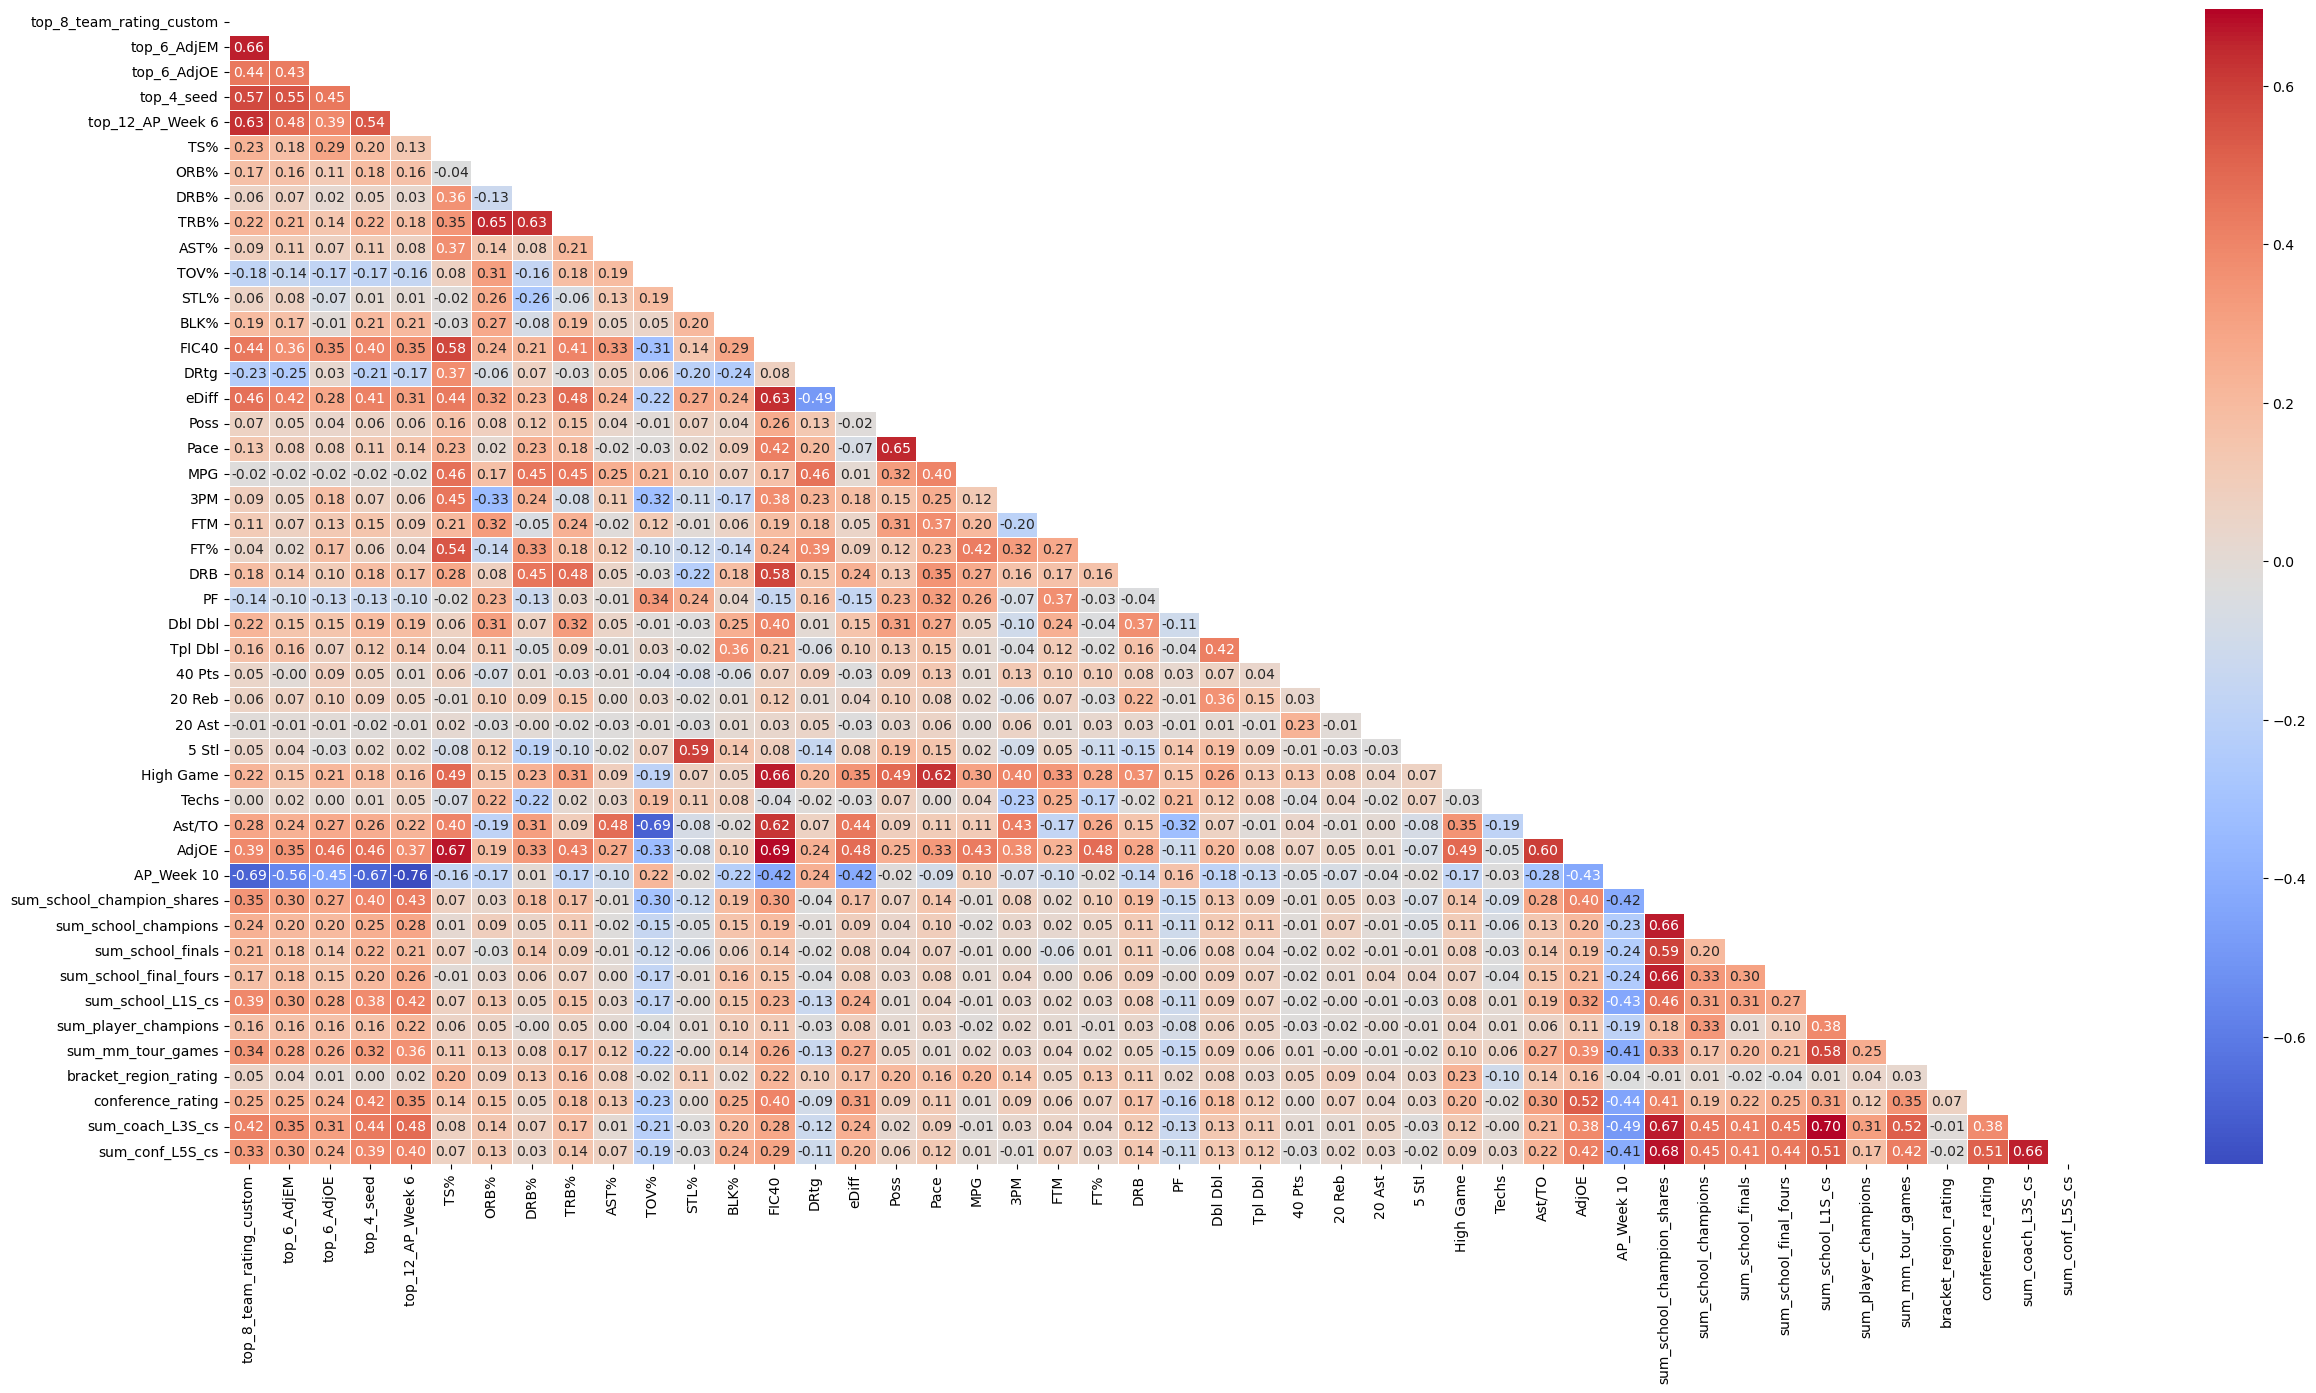

In [175]:
selected_features_data = data[features]
correlation_matrix = selected_features_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)
plt.show()

## Ridge Regression:

Results:

    Season            Team  champion_share  predicted_cs
0     2024           UConn        1.000000      0.572810
42    2024         Houston        0.333333      0.525029
43    2024         Arizona        0.333333      0.479509
2     2024          Purdue        0.833333      0.479283
44    2024  North Carolina        0.333333      0.464642
27    2024          Kansas        0.166667      0.439827
36    2024            Duke        0.500000      0.401734
6     2024          Baylor        0.166667      0.386479
52    2024          Auburn        0.000000      0.382269
10    2024       Tennessee        0.500000      0.375541
15    2024      Iowa State        0.333333      0.366446
34    2024        Kentucky        0.000000      0.351042
41    2024       Creighton        0.333333      0.344209
40    2024       Marquette        0.333333      0.329187
-----------------------------------------------------------------------------

NDCG Scores: 

True NDCG @:  0.9245193821981318
--------

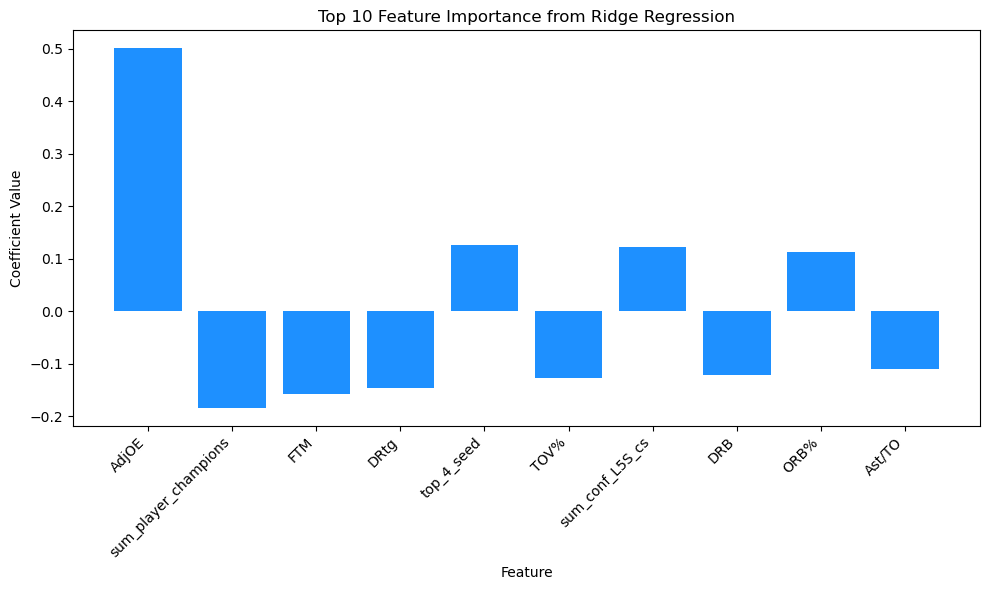

In [176]:
df.rename(columns={'season': 'Season'}, inplace=True)

train = df[df["Season"] < 2024].copy()
test = df[df["Season"] == 2024].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

rig = Ridge(alpha=0.5)
rig.fit(train[features], train["champion_share"])

predictions = rig.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

print("Results:")
print("=============================================================================\n")
print(frame.head(14))
print("-----------------------------------------------------------------------------\n")

def ndcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        dcg = np.sum(r / np.log2(np.arange(2, r.size + 2)))
        idcg = np.sum(np.sort(r)[::-1] / np.log2(np.arange(2, r.size + 2)))
        return dcg / idcg
    return 0.

def calculate_ndcg(df, k=14):
    true_relevance = df['champion_share'].values
    return ndcg_at_k(true_relevance, k=16)

ndcg_score_true = calculate_ndcg(frame, k=16)

print("NDCG Scores: ")
print("=============================================================================\n")
print("True NDCG @: ", ndcg_score_true)
print("-----------------------------------------------------------------------------\n")

coefficients = rig.coef_
feature_coefficients = dict(zip(features, coefficients))
sorted_feature_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

top_features = sorted_feature_coefficients[:10]
features_names = [x[0] for x in top_features]
coeff_values = [x[1] for x in top_features]

plt.figure(figsize=(10, 6))
plt.bar(features_names, coeff_values, color='dodgerblue')
plt.title('Top 10 Feature Importance from Ridge Regression')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

predictions = rig.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
rig_reg_frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
rig_reg_frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

In [177]:
actual = frame.sort_values("champion_share", ascending=False)
predicted = frame.sort_values("predicted_cs", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame):
    actual = frame.sort_values("champion_share", ascending=False).head(1) #HEAD

    predicted = frame.sort_values("predicted_cs", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame)
print("=============================================================================\n")
print("AP Champion: ", ap)

Ranking Accuracy (Champion):

   Season_x   Team  champion_share_x  predicted_cs_x  Rank  Season_y  champion_share_y  predicted_cs_y  Predicted Rank
0      2024  UConn               1.0         0.57281     1      2024               1.0         0.57281               1

AP Champion:  1.0


In [173]:
# Initialize the combined predictions DataFrame
rig_reg_combined_predictions = pd.DataFrame(columns=["Season", "Team/Season", "Team", "predicted_cs", "champion_share"])

all_predictions = []
aps = []
ndcgs = []

backtest_seasons = [2021,2022,2023,2024]
#backtest_seasons = [2024,2023,2022,2021,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010]

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rig.fit(train[features], train['champion_share'])
    predictions = rig.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
    frame = pd.concat([test[["Team", "champion_share", "Season"]], predictions_df], axis=1)

    frame['Team/Season'] = frame['Team'] + ' ' + frame['Season'].astype(str)

    # Append the predictions for the current season to the combined predictions DataFrame
    rig_reg_combined_predictions = pd.concat([rig_reg_combined_predictions, frame], ignore_index=True)

    if not frame.empty:
        all_predictions.append(frame)
        ap = find_ap(frame)
        aps.append(ap)

        ndcg = ndcg_score(frame["champion_share"].values.reshape(1, -1), predictions.reshape(1, -1))
        ndcgs.append(ndcg)

        reciprocal_ap = 1 / ap
        print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)} | NDCG: {round(ndcg, 2)}")
    else:
        print(f"No data for Season {season}")

for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted_cs", ascending=False).head(10)

    print(f"\nTop 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted_cs", "champion_share"]])

average_ndcg = np.mean(ndcgs)
average_ap = np.mean(aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_ndcg = 1.0 / average_ndcg

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average Champion Rank: {round(reciprocal_average_ap, 2)} | Reciprocal NDCG: {round(reciprocal_ndcg, 2)}")
print(f"Min Champion Rank: {round(reciprocal_min_ap, 2)}")
print(f"Max Champion Rank: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

rig_reg_combined_predictions.to_csv("rig_reg_ncaa_preds.csv", index=False)

Champion AP for Season 2021: 1.0 | Reciprocal: 1.0 | NDCG: 0.89
Champion AP for Season 2022: 0.5 | Reciprocal: 2.0 | NDCG: 0.8
Champion AP for Season 2023: 1.0 | Reciprocal: 1.0 | NDCG: 0.84
Champion AP for Season 2024: 1.0 | Reciprocal: 1.0 | NDCG: 0.89

Top 5 Predicted Teams for Season 2021:
          Team  predicted_cs  champion_share
225     Baylor      0.574932        1.000000
206    Gonzaga      0.557735        0.833333
212    Houston      0.537009        0.666667
209   Michigan      0.517333        0.500000
235    Colgate      0.495891        0.000000
197       Iowa      0.429517        0.166667
193   Illinois      0.378740        0.166667
196      Texas      0.357339        0.000000
194     Kansas      0.337143        0.166667
226  Villanova      0.323966        0.333333

Top 5 Predicted Teams for Season 2022:
          Team  predicted_cs  champion_share
131    Gonzaga      0.589458        0.333333
177     Kansas      0.544444        1.000000
133    Arizona      0.536353       

C:\Users\allen\AppData\Local\Temp\ipykernel_26636\3445745834.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rig_reg_combined_predictions = pd.concat([rig_reg_combined_predictions, frame], ignore_index=True)


## Analyzing Model Decision Making:

Top 10 Features:
['top_4_seed', 'AdjOE', 'sum_conf_L5S_cs', 'TOV%', 'Ast/TO', 'top_6_AdjEM', 'sum_mm_tour_games', 'sum_coach_L3S_cs', 'FTM', 'top_12_AP_Week 6']


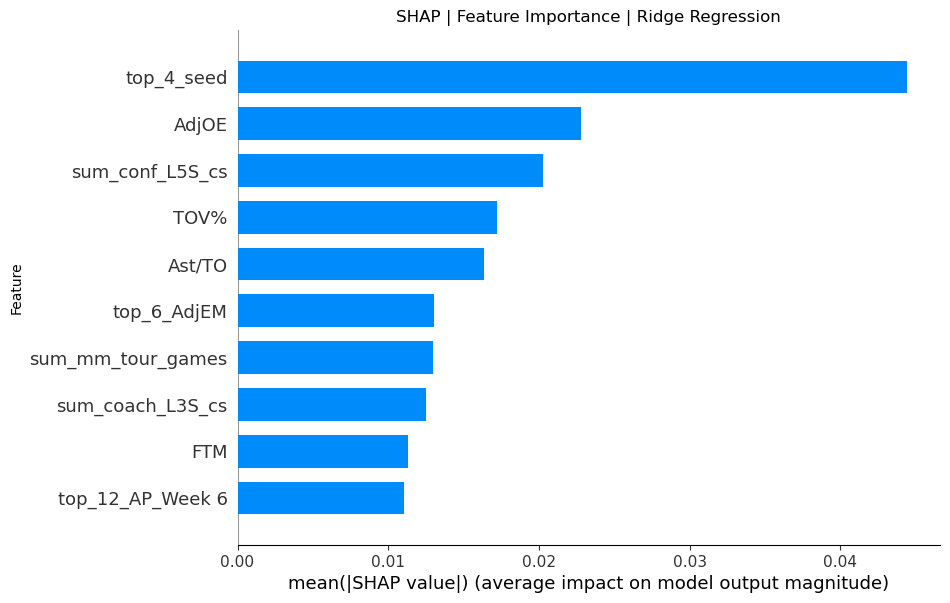

In [167]:
explainer = shap.LinearExplainer(rig, train[features])
shap_values = explainer.shap_values(test[features])

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1][:10]

top_features_list = [features[index] for index in top_features]
print("Top 10 Features:")
print(top_features_list)

shap_values_top = shap_values[:, top_features]
test_top_features = test[top_features_list]

shap.summary_plot(shap_values_top, test_top_features, feature_names=top_features_list, plot_type="bar", show=False)
plt.gcf().set_size_inches(10, 6)
plt.title('SHAP | Feature Importance | Ridge Regression')

plt.savefig("ridge_shap_bar.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("ridge_shap_bar.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("ridge_shap_bar.png")

plt.ylabel("Feature")
plt.show()

Top 10 Features:
['top_4_seed', 'AdjOE', 'sum_conf_L5S_cs', 'TOV%', 'Ast/TO', 'top_6_AdjEM', 'sum_mm_tour_games', 'sum_coach_L3S_cs', 'FTM', 'top_12_AP_Week 6']


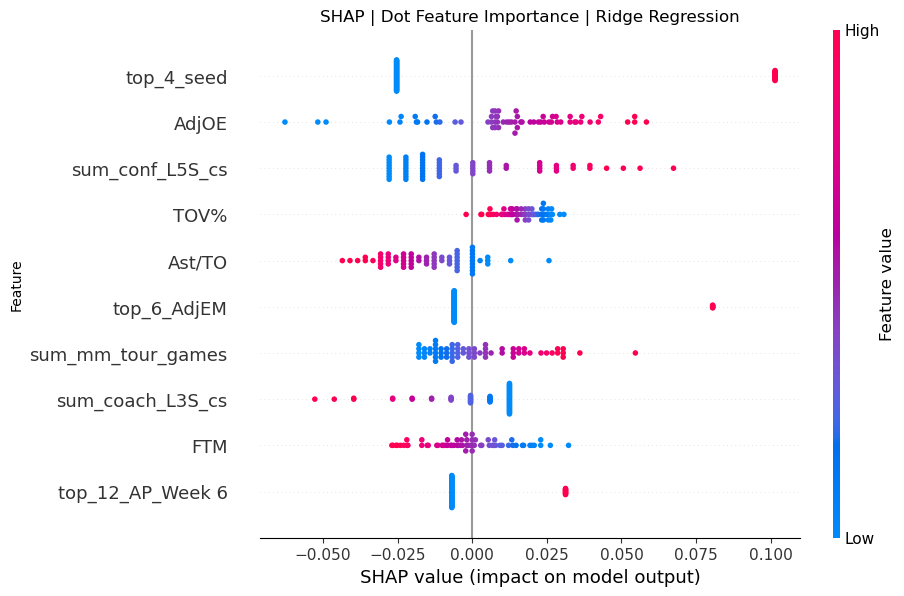

In [168]:

explainer = shap.LinearExplainer(rig, train[features])
shap_values = explainer.shap_values(test[features])

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1][:10]

top_features_list = [features[index] for index in top_features]
print("Top 10 Features:")
print(top_features_list)

shap_values_top = shap_values[:, top_features]
test_top_features = test[top_features_list]

shap.summary_plot(shap_values_top, test_top_features, feature_names=top_features_list, show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Dot Feature Importance | Ridge Regression')

plt.savefig("rig_shap_dot.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("rig_shap_dot.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("rig_shap_dot.png")

plt.ylabel("Feature")
plt.show()